In [1]:
from train import *
import numpy as np

# The script requires pytorch 1.4.0 and nvidia apex
# if using later pytorch versions, modify the training scripts and use GradScaler

In [2]:
# generate random sequences with specific motifs
select_motifs = [
    "ATCTATCTCCCAGATAGAT".replace("T", "U"),
    "CGCCATC".replace("T", "U"),
    "CGGGTAATCCCG".replace("T", "U")
]

num_examples = 5000 # If access to GPU, use > 5000, otherwise < 1000
np.random.seed(42)
alphabet = np.array(["A", "U", "C", "G"])
out_ar = np.zeros(num_examples, dtype="|U48")
motif_pos = np.zeros(num_examples)
resp_ar = np.array(["Bound"] * num_examples)
for i in range(num_examples):
    outseq = np.random.choice(alphabet, 48, replace=True)
    cur_motif = np.random.choice(select_motifs, 1)[0]
    rand_pos = np.random.choice(np.arange(25, 30), 1)[0]
    outseq[rand_pos:(rand_pos + len(cur_motif))] = list(cur_motif)
    out_ar[i] = "".join(list(outseq))
    motif_pos[i] = rand_pos

In [3]:
# generate random shuffles
num_examples_tune = int(num_examples * 9)
try:
    import ushuffle
    out_ar_neg = np.zeros(num_examples_tune, dtype="|U48")
    resp_ar_neg = np.array(["Unbound"] * num_examples_tune)
    j = 0
    for i in range(out_ar.shape[0]):
        curseq = out_ar[i].encode()
        shuffler = ushuffle.Shuffler(curseq, 2)
        for k in range(9):
            seqres = shuffler.shuffle()
            out_ar_neg[j] = seqres.decode()
            j += 1
except Exception:
    out_ar_neg = np.zeros(num_examples_tune, dtype="|U48")
    resp_ar_neg = np.array(["Unbound"] * num_examples_tune)
    for i in range(out_ar_neg.shape[0]):
        outseq = np.random.choice(alphabet, 48, replace=True)
        out_ar_neg[i] = "".join(list(outseq))

In [4]:
seqar = np.concatenate((out_ar, out_ar_neg), axis=0)
respar = np.concatenate((resp_ar, resp_ar_neg), axis=0)
ar_idxs = np.arange(seqar.shape[0])
np.random.shuffle(ar_idxs)
dict_data = {"Input": seqar[ar_idxs],
             "Response": respar[ar_idxs],
             "MFEs": np.zeros(seqar.shape[0])}
dict_data

{'Input': array(['UGGACCCCUCUAAGCCAGACAUGAGUUCGGUUCCCGGAGAUCCUAUAU',
        'GAAGCGCCCGAGAACCUACGUUGUAUAGCUCCCAUAUUGGCGAUGGGU',
        'AUACUAGGGGUCCGUCCCGGGGACCUUCCUUUCGUAACCCGAGUGGUA', ...,
        'CAUUUUUUCUCAUCGUACUACUGUAAGGGUCGUUCCCUACUAUCGGUU',
        'UCCCUCGGGGGUCGGCGUUAGUUAAUCGCCCUGACGGAAACAAGUAGA',
        'CUGCUAGCCAUCAGCGCCAACUAGGCAUCACCAGGCGUUACCGGGGGC'], dtype='<U48'),
 'Response': array(['Unbound', 'Unbound', 'Unbound', ..., 'Unbound', 'Unbound',
        'Unbound'], dtype='<U7'),
 'MFEs': array([0., 0., 0., ..., 0., 0., 0.])}

In [5]:
outdir = "notebook_data"
os.makedirs(outdir, exist_ok=True)
joblibpath = os.path.join(outdir, "example_data.joblib")
joblib.dump(dict_data, joblibpath, compress=9)

['notebook_data/example_data.joblib']

In [6]:
tensordict = split_dict(joblibpath)
tensordict.keys()

Splitting Training into 0-32000
Splitting Tuning into 32000-40000
Splitting Validation into 40000-50000


dict_keys(['Training', 'Tuning', 'Validation'])

In [7]:
tensordict_train = tensordict["Training"]
torch.manual_seed(42)

In [8]:
# load the model
inputsize = 48
optim_name = "Adam"
lr = 0.004
kernel_size = 16
conv_width = 64
dp = 0.5
trainable = False  # for the fixed dilated layer
dil_start = 2
dil_end = 24
bulge_size = 2
binarize_fd = True
model_name = "Pythia"
disable_conv_dp = False
useRegConv = False
modelparams = get_model_params(
    inputsize, optim_name, lr, kernel_size, conv_width, dp,
    trainable, dil_start, dil_end, bulge_size, binarize_fd,
    model_name, disable_conv_dp)
modelparams

{'optimizer': 'Adam',
 'inputsize': 48,
 'lr': 0.004,
 'dp': 0.5,
 'conv_width': 64,
 'kernel': 16,
 'dilationTraining': False,
 'dil_start': 2,
 'dil_end': 24,
 'bulge_size': 2,
 'binarize_fd': True,
 'model_name': 'Pythia',
 'DisConvDP': False}

In [9]:
dictpaths = compile_paths(outdir, modelparams,
                          useRegConv=useRegConv)
chkpaths = dictpaths["chkpaths"] +\
    [dictpaths["bestpath"], dictpaths["modelpath"]]
print(chkpaths)
net, optimizer = load_model(
    inputsize, outdir, optim_name, lr, chkpaths,
    useRegConv, kernel_size, conv_width, dp, trainable,
    dil_start, dil_end, bulge_size, binarize_fd, model_name,
    disable_conv_dp)

['/checkpoint/mkarimza/8572390/pythiaModel_optimizer-Adam_inputsize-48_lr-0.004_dp-0.5_conv_width-64_kernel-16_dilationTraining-False_dil_start-2_dil_end-24_bulge_size-2_binarize_fd-True_model_name-Pythia_DisConvDP-FalselossScale_1_1_0.pt', '/checkpoint/mkarimza/8572390/pythiaModel_optimizer-Adam_inputsize-48_lr-0.004_dp-0.5_conv_width-64_kernel-16_dilationTraining-False_dil_start-2_dil_end-24_bulge_size-2_binarize_fd-True_model_name-Pythia_DisConvDP-FalselossScale_1_1_1.pt', 'notebook_data/pythiaModel_optimizer-Adam_inputsize-48_lr-0.004_dp-0.5_conv_width-64_kernel-16_dilationTraining-False_dil_start-2_dil_end-24_bulge_size-2_binarize_fd-True_model_name-Pythia_DisConvDP-FalselossScale_1_1/pythiaModel_optimizer-Adam_inputsize-48_lr-0.004_dp-0.5_conv_width-64_kernel-16_dilationTraining-False_dil_start-2_dil_end-24_bulge_size-2_binarize_fd-True_model_name-Pythia_DisConvDP-FalselossScale_1_1_best.pt', 'notebook_data/pythiaModel_optimizer-Adam_inputsize-48_lr-0.004_dp-0.5_conv_width-64_ker

Splitting Training into 0-32000
Splitting Tuning into 32000-40000
Splitting Validation into 40000-50000
Making notebook_data/pythiaModel_optimizer-Adam_inputsize-48_lr-0.004_dp-0.5_conv_width-64_kernel-16_dilationTraining-False_dil_start-2_dil_end-24_bulge_size-2_binarize_fd-True_model_name-Pythia_DisConvDP-FalselossScale_1_1/2022-09-20_10modelTraining.log
Assessing Training


/pkgs/pytorch-1.4-cuda10.1-conda-python3.6/apex/amp/wrap.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return orig_fn(*new_args, **kwargs)


Assessing Tuning


/pkgs/pytorch-1.4-cuda10.1-conda-python3.6/apex/amp/wrap.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return orig_fn(*new_args, **kwargs)


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
Assessing Training


/pkgs/pytorch-1.4-cuda10.1-conda-python3.6/apex/amp/wrap.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return orig_fn(*new_args, **kwargs)


Assessing Tuning


/pkgs/pytorch-1.4-cuda10.1-conda-python3.6/apex/amp/wrap.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return orig_fn(*new_args, **kwargs)


Epoch 0: Training Loss: 1.152257839591838 Tuning loss: 0.0118
Assessing Training


/pkgs/pytorch-1.4-cuda10.1-conda-python3.6/apex/amp/wrap.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return orig_fn(*new_args, **kwargs)


Assessing Tuning


/pkgs/pytorch-1.4-cuda10.1-conda-python3.6/apex/amp/wrap.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return orig_fn(*new_args, **kwargs)


Epoch 1: Training Loss: 0.01763018455593007 Tuning loss: 0.0101
Assessing Training


/pkgs/pytorch-1.4-cuda10.1-conda-python3.6/apex/amp/wrap.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return orig_fn(*new_args, **kwargs)


Assessing Tuning


/pkgs/pytorch-1.4-cuda10.1-conda-python3.6/apex/amp/wrap.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return orig_fn(*new_args, **kwargs)


Epoch 2: Training Loss: 0.015293013785877952 Tuning loss: 0.0729
Assessing Training


/pkgs/pytorch-1.4-cuda10.1-conda-python3.6/apex/amp/wrap.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return orig_fn(*new_args, **kwargs)


Assessing Tuning


/pkgs/pytorch-1.4-cuda10.1-conda-python3.6/apex/amp/wrap.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return orig_fn(*new_args, **kwargs)


Epoch 3: Training Loss: 0.005360491478268905 Tuning loss: 0.0376
Assessing Training


/pkgs/pytorch-1.4-cuda10.1-conda-python3.6/apex/amp/wrap.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return orig_fn(*new_args, **kwargs)


Assessing Tuning


/pkgs/pytorch-1.4-cuda10.1-conda-python3.6/apex/amp/wrap.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return orig_fn(*new_args, **kwargs)


Epoch 4: Training Loss: 0.00237875124459278 Tuning loss: 0.011
Assessing Training


/pkgs/pytorch-1.4-cuda10.1-conda-python3.6/apex/amp/wrap.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return orig_fn(*new_args, **kwargs)


Assessing Tuning


/pkgs/pytorch-1.4-cuda10.1-conda-python3.6/apex/amp/wrap.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return orig_fn(*new_args, **kwargs)


Epoch 5: Training Loss: 0.0019165080135042176 Tuning loss: 0.0149
Assessing Training


/pkgs/pytorch-1.4-cuda10.1-conda-python3.6/apex/amp/wrap.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return orig_fn(*new_args, **kwargs)


Assessing Tuning


/pkgs/pytorch-1.4-cuda10.1-conda-python3.6/apex/amp/wrap.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return orig_fn(*new_args, **kwargs)


Epoch 6: Training Loss: 0.00046108087849088556 Tuning loss: 0.0125
Assessing Training


/pkgs/pytorch-1.4-cuda10.1-conda-python3.6/apex/amp/wrap.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return orig_fn(*new_args, **kwargs)


Assessing Tuning


/pkgs/pytorch-1.4-cuda10.1-conda-python3.6/apex/amp/wrap.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return orig_fn(*new_args, **kwargs)


Epoch 7: Training Loss: 5.6373294571175555e-05 Tuning loss: 0.0144
Assessing Training


/pkgs/pytorch-1.4-cuda10.1-conda-python3.6/apex/amp/wrap.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return orig_fn(*new_args, **kwargs)


Assessing Tuning


/pkgs/pytorch-1.4-cuda10.1-conda-python3.6/apex/amp/wrap.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return orig_fn(*new_args, **kwargs)


Epoch 8: Training Loss: 1.494900023123487e-05 Tuning loss: 0.0139
Assessing Training


/pkgs/pytorch-1.4-cuda10.1-conda-python3.6/apex/amp/wrap.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return orig_fn(*new_args, **kwargs)


Assessing Tuning


/pkgs/pytorch-1.4-cuda10.1-conda-python3.6/apex/amp/wrap.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return orig_fn(*new_args, **kwargs)


Epoch 9: Training Loss: 1.1079244042447812e-05 Tuning loss: 0.0138
Assessing Training


/pkgs/pytorch-1.4-cuda10.1-conda-python3.6/apex/amp/wrap.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return orig_fn(*new_args, **kwargs)


Assessing Tuning


/pkgs/pytorch-1.4-cuda10.1-conda-python3.6/apex/amp/wrap.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return orig_fn(*new_args, **kwargs)


Epoch 10: Training Loss: 9.057211862633922e-06 Tuning loss: 0.0139


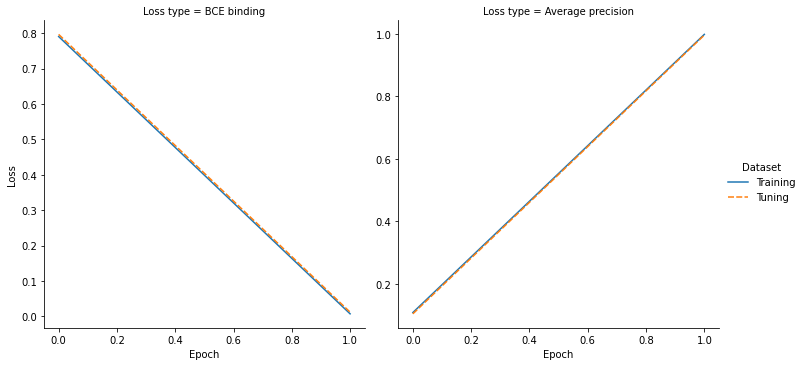

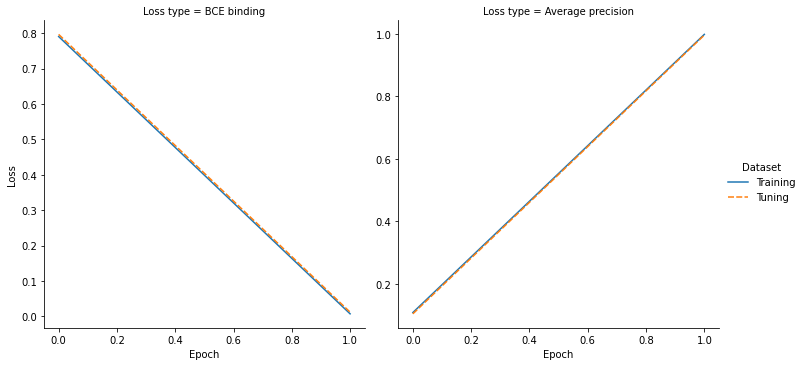

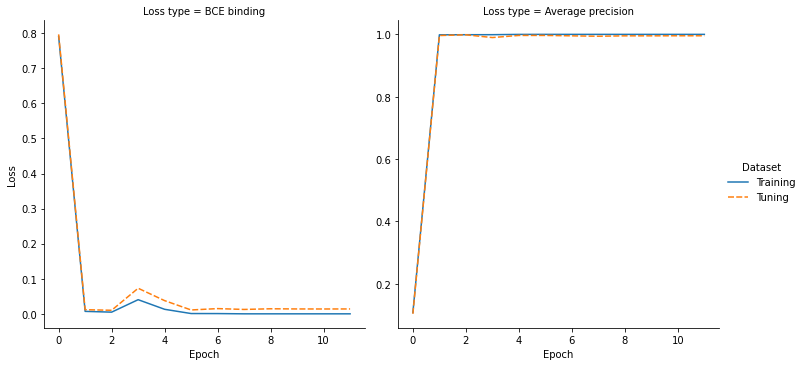

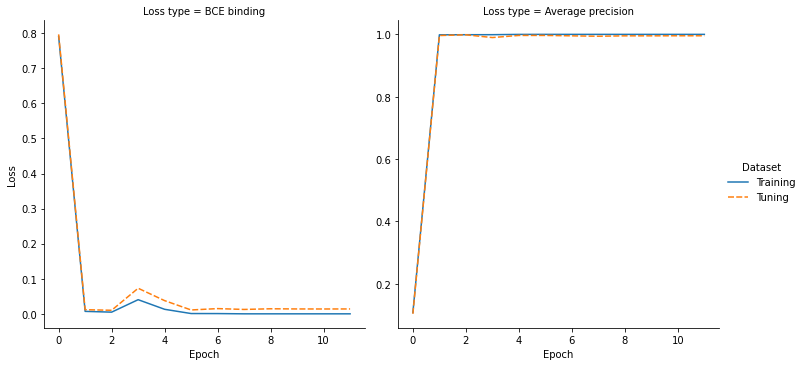

In [10]:
train_model(joblibpath, dictpaths, net, optimizer, model_name=model_name, MAXEPOCHS=11, MINIBATCH=512)

In [11]:
from predict import *

In [12]:
net.eval()
outpath = os.path.join(outdir, "model_performance.tsv.gz")
apply_model(
        joblibpath, net, outpath, model_name=model_name)

Splitting Training into 0-32000
Splitting Tuning into 32000-40000
Splitting Validation into 40000-50000


/pkgs/pytorch-1.4-cuda10.1-conda-python3.6/apex/amp/wrap.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return orig_fn(*new_args, **kwargs)


notebook_data/model_performance.tsv.gz


In [13]:
# look into the output directory and examine the log file and model_performance.tsv.gz file

In [15]:
perfdf = pd.read_csv(outpath, sep="\t", compression="gzip")
perfdf.head()

,Response,Pred.Response,Input,MFEs,BCE,Average.Precision,Accuracy
0,Unbound,6.448779e-09,AUACCGAUGGAGGGCGAGACAGGGAUUAUCCUAAUUAGAUCUCAGCCA,0.0,0.013541,0.998258,0.9978
1,Unbound,3.321419e-05,GAUCUAGAGAGGGGAUCCACAUUCAUCAGCCAUGCUAUCACUCCUACC,0.0,0.013541,0.998258,0.9978
2,Bound,9.999999e-01,CCGUCAGAUUUGCGAGAGCAUUGUAAUCUAUCUCCCAGAUAGAUUGAC,0.0,0.013541,0.998258,0.9978
3,Unbound,7.512231e-07,GCUUCCGCUAACAGUCUUUUACUGCACGCACCCGAAUAGGAGCAUGCC,0.0,0.013541,0.998258,0.9978
4,Unbound,4.718028e-09,GUCAGCUCUACAAUACCCUAGACAUCAGCUAAUGUAAAUCCGGAUAUA,0.0,0.013541,0.998258,0.9978


<AxesSubplot:xlabel='Response', ylabel='Pred.Response'>

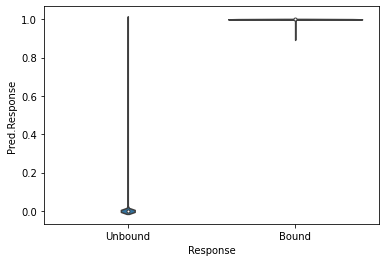

In [17]:
import seaborn as sns
sns.violinplot(y="Pred.Response", x="Response", data=perfdf)